In [1]:
%%capture
!pip install mtcnn
!pip install youtube_dl
!pip install ffmpeg-python
!pip3 install matplotlib
!pip3 install ffmpeg-python
!pip3 install imageio-ffmpeg

In [2]:
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import youtube_dl

In [6]:
yl = youtube_dl.YoutubeDL({'format': 'best'})

In [2]:
#from video_to_images import *

### We have all the video clips, we need to simply save them as images
The format in which we need to save is provided below

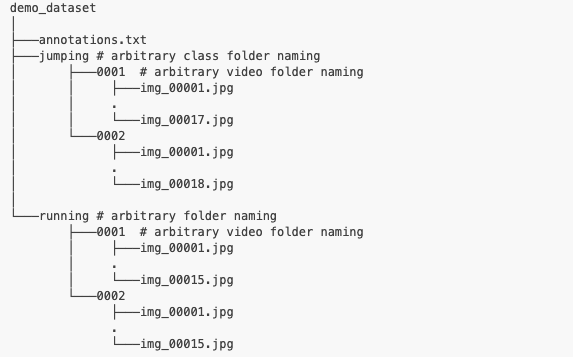

In [ ]:
#for each video category
#create the folder for the video category
#save the set of images in there with the proper naming as expected, e.g. we need images from seq. 0001 - 0250

In [19]:
def getproperties(url):
    m3u8, width, height, fps = None, None, None, None
    try:
        quality = yl.extract_info(url, download=False)
        m3u8 = quality['url']
        width = quality['width']
        height = quality['height']
        fps = quality['fps']
    except Exception as e:
        print("Error downloading the metadata for the video url {}, error {}".format(url, e.__class__))
        raise Exception("Metadata fetch error")
    return m3u8, width, height, fps


import re
""" Get the size of the video frames from the metadata of the downloaded stream
    This has been tested to work with the metadata from the youtube video streams only
"""
def getsize(prop):
    """
    Args:
        a byte array
    Returns:
        (int, int): width and height of the video frames
    """
    grp = None
    width = None
    height = None
    #get the part of the bytes after rgb24
    p = re.compile(rb'rgb24\s*(.*)')
    try:
        m = p.search(prop)
        if m:
            grp = m.group(1)
        p = re.compile(rb'((\d+)(\s|x|\.)(\d+))')
        m = p.search(grp)
        try:
            if m:
                width = int(m.group(2))
                height = int(m.group(4))
        except:
            print("Error when extracting the size from the downloaded video stream!")
    except:
        print("Error parsing the properties of the downloaded video")
        raise Exception("Get size error")
    return width, height

import ffmpeg
"""
    Download the video using the video stream link, fps and a provided width for scaling the frames
"""
def downloadvideo(m3u8, fps, startsecs, durationsecs, width=360):
    try:
        out, prop = (
                ffmpeg
                .input(m3u8, ss=startsecs, t=durationsecs) #use this instead of trim
                #.trim(start_frame=stfr, end_frame=enfr) #buggy, does not work!
                .filter('fps', fps=fps, round='up')
                .filter('scale', 360, -1)
                .output('pipe:', format='rawvideo', pix_fmt='rgb24')
                .run(capture_stdout=True, quiet = True))
    except Exception as e:
        print("Error reading the video stream, error was {}".format(e.__class__))
        raise Exception("Download error")
    return out, prop

def getvideo(out, width, height):
    try:
        video = (np.frombuffer(out, np.uint8).reshape([-1, width, height, 3]))  
    except:
        print("Error reshaping video byte array to numpy array")
        raise Exception("Fetch video error")
    return video

In [20]:
import imageio
import os
import traceback
import sys
"""
    Parse all videos in the video_list and generate image files for training
"""
def parsevideos(video_list, clip_len=None, save_images=True, save_videos=False, rootpath=None, videopath=None):
    """
        Arg: video_list is a dictionary of url (a youtube video link) and the category: string
             Optional: clip_len: int, length of the clip in seconds, default = 30
                       save_images: save the images from the frames to directory named after the category, default = True
                       save_videos: save the videos to a directory in videopath, default = False
                       rootpath: the directory for the training images
                       videopath: the directory for the extracted videos
    """
    annotationsfile = "annotations.txt"
    clsses = {}
    free_ids = 0
    defaultcliplen = 30 #seconds
    if clip_len is not None:
        cliplen = int(clip_len)
    else:
        cliplen = defaultcliplen
    if rootpath is None:
        raise ValueError("rootpath must be provided.")
    vid_idx = 0
    #clean up old annotations file
    annotationsfilepath = rootpath + "/" + annotationsfile
    try:
        os.remove(annotationsfilepath)
    except:
        print("Error removing the annotations file {}".format(annotationsfilepath))
    for vl in video_list:
        try:
            #get the metadata for the video
            if 'url' in vl:
                url = vl['url']
            else:
                raise Exception("No video url provided, skipping...")
            m3u8, width, height, fps = getproperties(url)
            #get the start and end frame requirements for the video, if provided 
            if 'start' in vl:
                start = int(vl['start'])
            else: 
                start = 0
            if 'end' in vl:
                end = int(vl['end'])
            else:
                end = cliplen
            #get the category of the video
            if 'category' in vl:
                category = vl['category']
            else:
                raise Exception("No category specified for the video {}".format(url))
            #get the class id for the category
            if category not in clsses:
                clsses[category] = free_ids
                free_ids += 1
            class_id = clsses[category]
            print("Class id is {}".format(class_id))
            print("Downloading from {} to {} of length {}".format(start, end, end-start))
            out, prop = downloadvideo(m3u8, fps, start, end - start, width/2)
            width, height = getsize(prop)
            #the numpy array of the video
            video = getvideo(out, height, width)
            if videopath is not None:
                pathtovideo = os.path.join(videopath + "/" + category)
                if not os.path.exists(pathtovideo):
                    os.makedirs(pathtovideo)
                fullpath = pathtovideo + "/" + "video{}.mp4".format(vid_idx)
                print("Saving video to {}".format(fullpath))
                imageio.mimwrite(fullpath, video , fps = fps)
            if rootpath is not None:
                #create a folder to save the images from the video, some arbritrary naming
                #we will use the index of the video
                pathtoimages = os.path.join(rootpath + "/" + category + "/" + str(vid_idx))
                if not os.path.exists(pathtoimages):
                    os.makedirs(pathtoimages)
                for idx in range(video.shape[0]):
                    fullpath = pathtoimages + "/" + "img_{}.jpg".format(idx)
                    im = Image.fromarray(video[idx])
                    im.save(fullpath)
                frame_cnt = video.shape[0]
                print("Saved {} images in {}".format(frame_cnt, pathtoimages))
                #write the image paths to the annotations file, path, start frame, end frame, class id
                with open(annotationsfilepath, 'a') as filetowrite:
                    filetowrite.write("{}/{} {} {} {}\n".format(category, vid_idx, 0, frame_cnt, class_id))
                
            vid_idx += 1
        except Exception as e:
            print(e)
            traceback.print_exception(*sys.exc_info())
            print("Error in processing the video at {}".format(vl['url']))
            continue

In [3]:
#note, you will errors when downloading from youtube, this could be due to connection timeout errors or other errors, since we provide a whole lot of vidoes
#for training, its should be OK it about 10-15% of them error out when processing
video_list = [{'url': "https://www.youtube.com/watch?v=GEda-tkB8Yc", 'category': 'pedestrain', 'start': 18, 'end': 26}, 
             {'url': "https://www.youtube.com/watch?v=t4Fy6AUMv8E", 'category': 'avengers', 'start': 10, 'end': 20},
             {'url': "https://www.youtube.com/watch?v=tzKilUvWe8U", 'category': 'cyclists', 'start': 87, 'end': 93},
             {"url": "https://www.youtube.com/watch?v=ckXBf7b-q4U", 'category': 'pedestrain', 'start': 118, 'end': 125},
             {"url": "https://www.youtube.com/watch?v=pQKYN-yR2oM", 'category': 'avengers', 'start': 63, 'end': 72}]
#get at least 30 seconds of clip from the video
parsevideos(video_list, clip_len=30, videopath="youtubevideos", rootpath="demo_dataset")

Error removing the annotations file demo_dataset/annotations.txt
[youtube] GEda-tkB8Yc: Downloading webpage
Class id is 0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (360, 203) to (368, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saving video to youtubevideos/pedestrain/video0.mp4
Saved 241 images in demo_dataset/pedestrain/0
[youtube] t4Fy6AUMv8E: Downloading webpage
Class id is 1


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (360, 203) to (368, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saving video to youtubevideos/avengers/video1.mp4
Saved 203 images in demo_dataset/avengers/1
[youtube] tzKilUvWe8U: Downloading webpage
Class id is 2


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (360, 203) to (368, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saving video to youtubevideos/cyclists/video2.mp4
Saved 181 images in demo_dataset/cyclists/2
[youtube] ckXBf7b-q4U: Downloading webpage
Class id is 0
Error reading the video stream, error was <class 'ffmpeg._run.Error'>
Download error
Error in processing the video at https://www.youtube.com/watch?v=ckXBf7b-q4U
[youtube] pQKYN-yR2oM: Downloading webpage


Traceback (most recent call last):
  File "/app/video_to_images.py", line 65, in downloadvideo
    ffmpeg
  File "/opt/conda/lib/python3.8/site-packages/ffmpeg/_run.py", line 325, in run
    raise Error('ffmpeg', out, err)
ffmpeg._run.Error: ffmpeg error (see stderr output for detail)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/app/video_to_images.py", line 147, in parsevideos
    out, prop = downloadvideo(m3u8, fps, start, end - start, width/2)
  File "/app/video_to_images.py", line 74, in downloadvideo
    raise Exception("Download error")
Exception: Download error


Class id is 1


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (360, 203) to (368, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saving video to youtubevideos/avengers/video3.mp4
Saved 272 images in demo_dataset/avengers/3


In [4]:
cat demo_dataset/annotations.txt

pedestrain/0 0 241 0
avengers/1 0 203 1
cyclists/2 0 181 2
avengers/3 0 272 1


### Test if we generated the images properly

In [5]:
cat demo_dataset/annotations.txt

pedestrain/0 0 241 0
avengers/1 0 203 1
cyclists/2 0 181 2
avengers/3 0 272 1


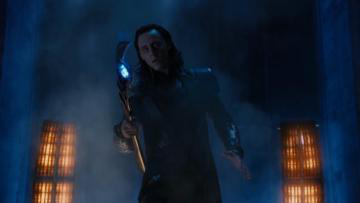

In [6]:
Image.open('demo_dataset/avengers/2/img_126.jpg')

In [7]:
from IPython.display import Video
videopath = "youtubevideos/avengers/video2.mp4"
Video(videopath)

### We will now process the images to generate the training datasets

In [8]:
from video_dataset import  VideoFrameDataset, ImglistToTensor, VideoRecord
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

In [9]:
preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(299),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(299),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
dataset = VideoFrameDataset(
        root_path="demo_dataset",
        annotationfile_path="demo_dataset/annotations.txt",
        num_segments=5,
        frames_per_segment=1,
        imagefile_template='img_{:d}.jpg',
        transform=preprocess,
        random_shift=True,
        test_mode=False
    )

Video Tensor Size: torch.Size([5, 3, 299, 299])


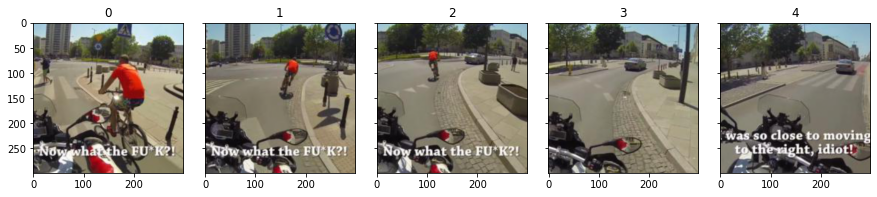

In [10]:
def denormalize(video_tensor):
        """
        Undoes mean/standard deviation normalization, zero to one scaling,
        and channel rearrangement for a batch of images.
        args:
            video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        """
        inverse_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
        return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()
def plot_video(rows, cols, frame_list, plot_width, plot_height):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.show()
sample = dataset[2]
frame_tensor = sample[0]
label = sample[1]
print('Video Tensor Size:', frame_tensor.size())
frame_tensor = denormalize(frame_tensor)
plot_video(rows=1, cols=5, frame_list=frame_tensor, plot_width=15., plot_height=3.)